In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import logging
from glob import glob
import os

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

logging.basicConfig(level=logging.INFO)
sys.path.append('..')
from src.models import get_model, SteganographyModels
from src.__main__ import CLI
from src.config import TMP_FOLDER

print("Available models:")
print('\n'.join(list(map(lambda x: str(x).split('.')[-1], SteganographyModels))))

Available models:
LSB
BASE_MERGE
PVD
GLM
WT
DCT


## Constants

In [3]:
IMAGE_PATH = "../tests/test_images/cat.jpg"
#IMAGE_PATH = "../tests/test_messages/cs.png"

MODEL_NAME = "PVD"

MESSAGE = """Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.""" * 50
#MESSAGE = "../tests/test_images/casoar.jpeg"
#MESSAGE = "../tests/test_messages/noisette.jpg"

## Show image and hide the image

In [4]:
cli = CLI()

INFO:CLI:Starting your request !


INFO:CLI:Loading image.


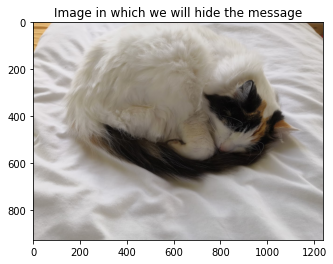

In [5]:
image = cli._load_image(IMAGE_PATH)
plt.figure()
plt.title("Image in which we will hide the message")
plt.imshow(image)
plt.show()

In [6]:
message = cli._load_message(MESSAGE)

if isinstance(message, str):
    print(message[:300])
else:
    plt.figure()
    plt.title("Message to hide")
    plt.imshow(message)
    plt.show()

INFO:CLI:Loading message to hide.
INFO:CLI:We consider this is a plain text


Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the 


In [7]:
model = get_model(MODEL_NAME)

In [8]:
encoded_image = model.encode(
    image=image, message=message
)
print(encoded_image.shape)

(929, 1239, 3)


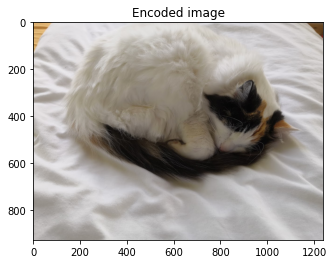

In [9]:
plt.figure()
plt.imshow(encoded_image)
plt.title("Encoded image")
plt.savefig('../docs/encoded_image.png')
plt.show()

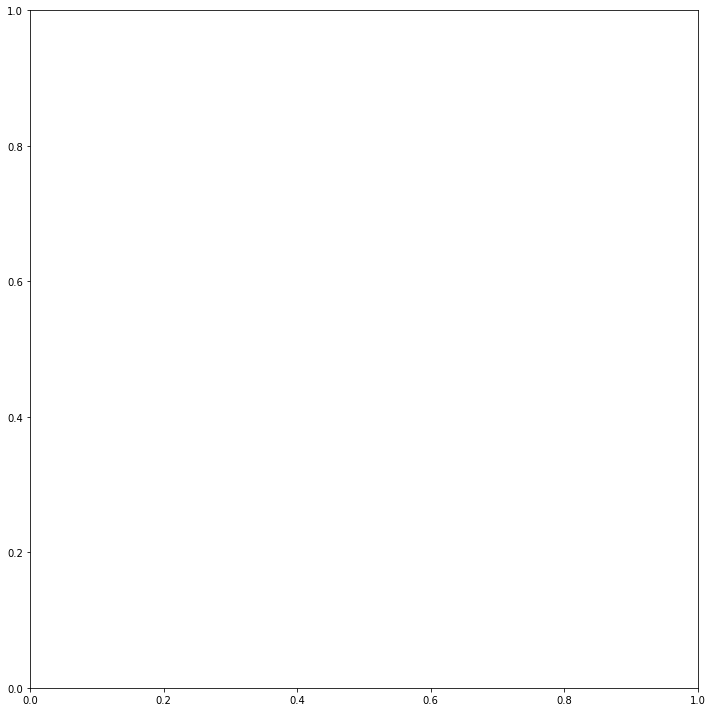

In [10]:
# Display the other images (in the tmp folder)
matrices_paths = list(glob(os.path.join(TMP_FOLDER, "*.npy")))
matrices = list(map(lambda x: (x, np.load(x, allow_pickle=True)), matrices_paths))
matrices = list(filter(lambda x: x[1].ndim >=2, matrices))

nbr_per_line = 3
names = list(map(lambda x: x[0], matrices))
names += [None for _ in range(nbr_per_line - len(names) % nbr_per_line)]
# convert names to a 2D of size 3
names = np.array(names).reshape(nbr_per_line, -1)
fig, axd = plt.subplot_mosaic(names, figsize=(10, 10))
plt.tight_layout()

for matrix_path, matrix in matrices:
    ax = axd[matrix_path]
    ax.imshow(matrix)
    ax.set_title(os.path.basename(matrix_path))


In [12]:
# Retrieve the message
if isinstance(message, str):
    retrieved_message = model.decode_str(encoded_image)
else:
    retrieved_message = model.decode_img(encoded_image)

# Display the retrieved message
if isinstance(retrieved_message, str):
    print('Decoded message:')
    print(retrieved_message[:40])
    assert retrieved_message == MESSAGE, "The messages are not the same"
else:
    plt.figure()
    plt.title("Decoded message")
    plt.imshow(retrieved_message)
    plt.show()

Decoded message:
Not found: 'Lorem Ipsum is simply dummy 


AssertionError: The messages are not the same

## Data analysis

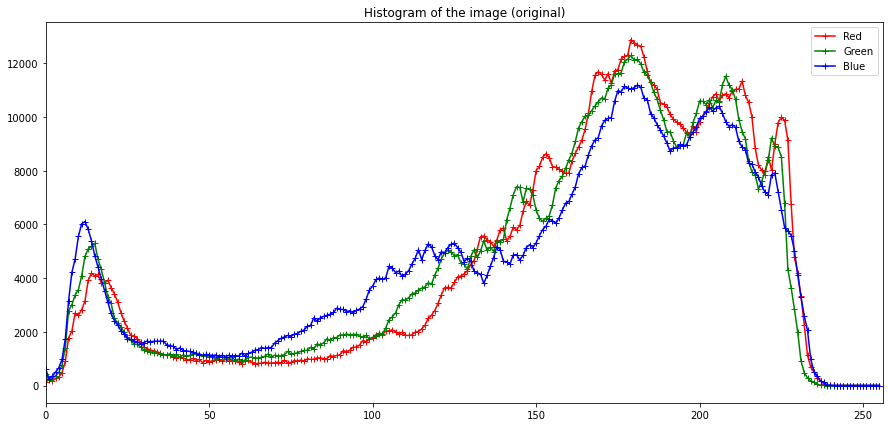

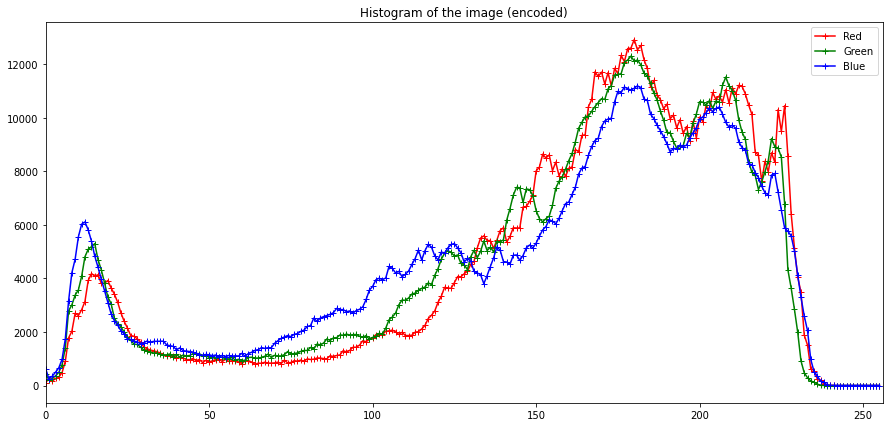

In [ ]:
from src.analysis.histogram import generate_histogram, plot_histogram, compare_histograms, compute_diff_imgs

image_histo = generate_histogram(image)
encoded_image_histo = generate_histogram(encoded_image)

plt.figure(figsize=(15,7))
plt.title('Histogram of the image (original)')
plot_histogram(image_histo)
plt.savefig('../docs/histo_original.png')
plt.figure(figsize=(15,7))
plt.title('Histogram of the image (encoded)')
plot_histogram(encoded_image_histo)
plt.savefig('../docs/histo_encoded.png')

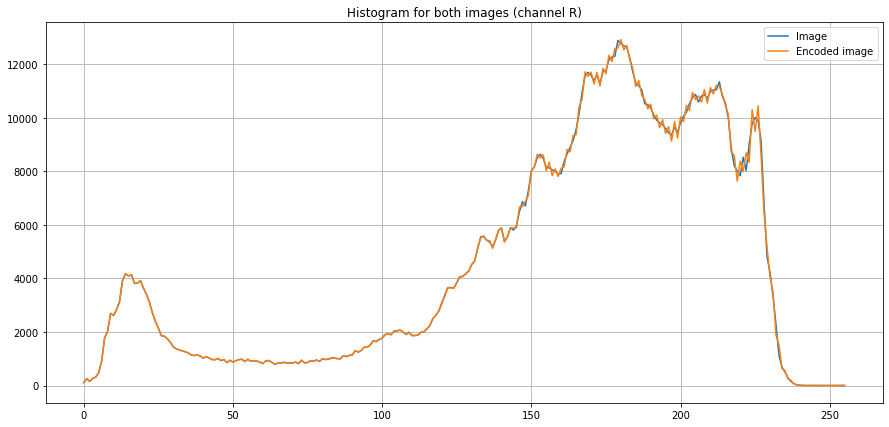

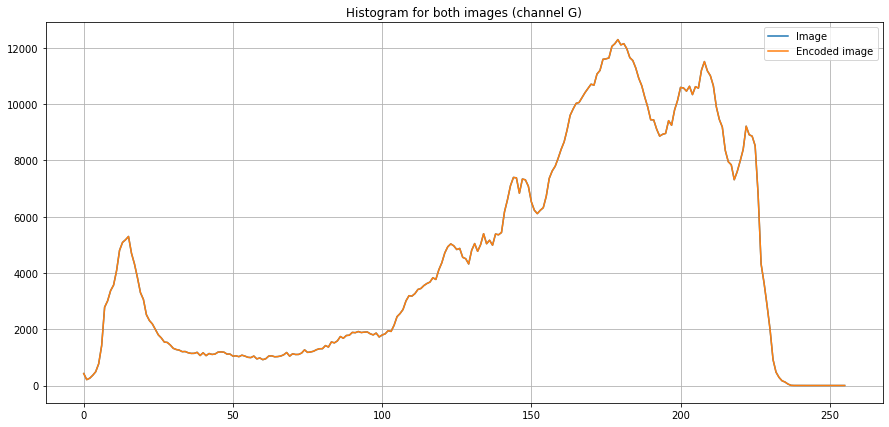

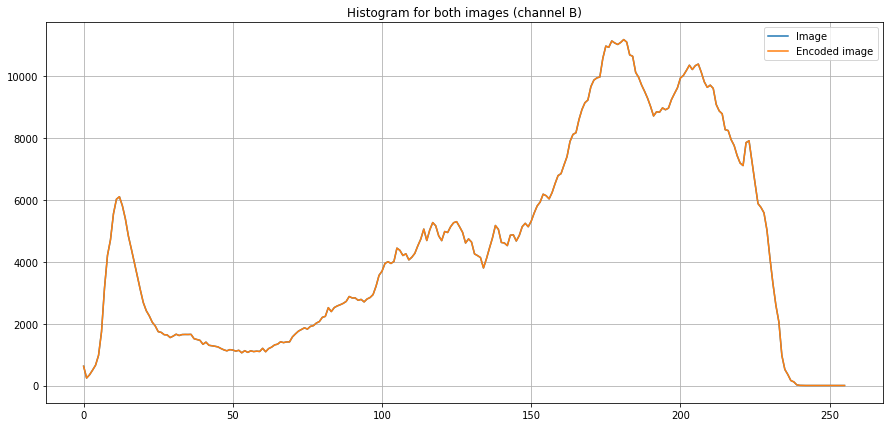

In [65]:
for i, channel in enumerate("RGB"):
    plt.figure(figsize=(15,7))
    plt.title(f"Histogram for both images (channel {channel})")
    plt.plot(image_histo[i], label="Image")
    plt.plot(encoded_image_histo[i], label="Encoded image")
    plt.legend()
    plt.savefig(f"../docs/hist_comparison_channel_{channel}.png")
    plt.grid()
    

        score     image channel
0  123.039795   Encoded       R
1  117.069374   Encoded       G
2  111.428413   Encoded       B
0  116.351517  Original       R
1  117.069374  Original       G
2  111.428413  Original       B


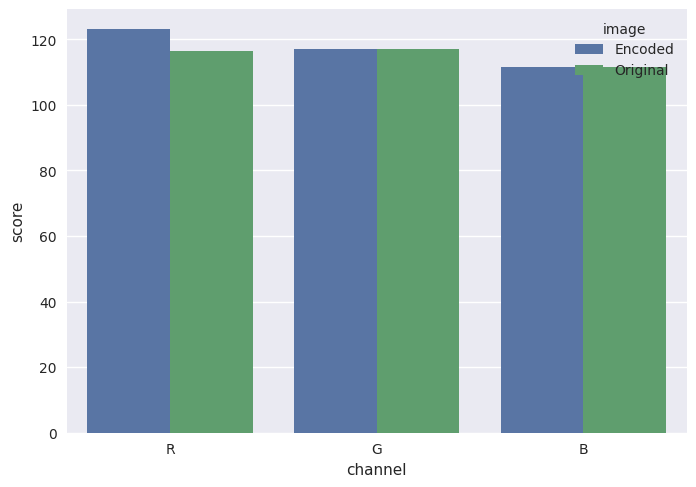

In [ ]:
from src.analysis.histogram import histogram_anomaly_score

hist = generate_histogram(image)
anomaly_scores_original = histogram_anomaly_score(hist)

hist = generate_histogram(encoded_image)
anomaly_scores_encoded = histogram_anomaly_score(hist)

df = pd.concat([
    pd.DataFrame({
        "score": score,
        "image": image_name,
        "channel": list("RGB")
    })
    for score, image_name in zip([anomaly_scores_encoded, anomaly_scores_original], ['Encoded', 'Original'])
])
print(df.head(6))
plt.style.use('seaborn')
sns.barplot(data=df, x="channel", y="score", hue="image")
plt.style.use("default")
plt.show()

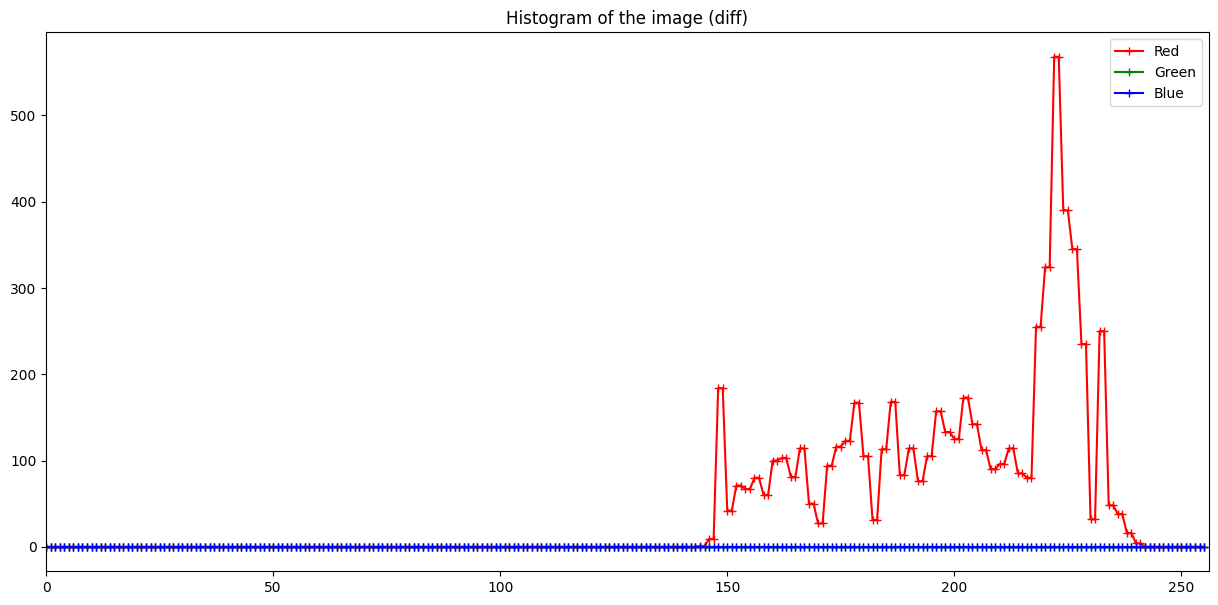

In [157]:
plt.figure(figsize=(15,7))
plt.title('Histogram of the image (diff)')

plot_histogram(
    compare_histograms(
        generate_histogram(image),
        generate_histogram(encoded_image)
    )
)
plt.savefig('../docs/histogram_diff.png')
plt.show()

(929, 1239, 3) (929, 1239, 3)


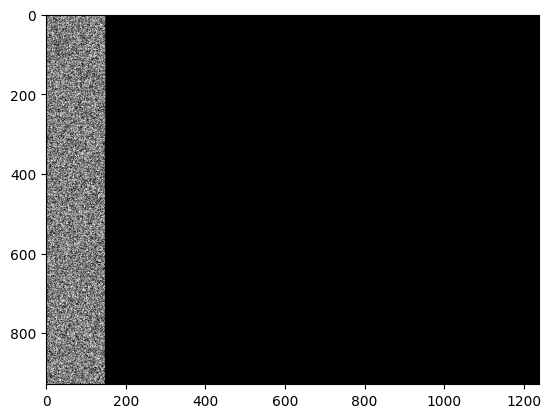

In [158]:
print(image.shape, encoded_image.shape)
image_ = cv2.resize(image, (encoded_image.shape[1], encoded_image.shape[0]))
plt.imshow(compute_diff_imgs(image_, encoded_image), cmap='gray');

d:\Documents\stenography\notebooks\..\src\analysis\least_significant_bit.py:37: UserWarning: Possible precision loss converting image of type int32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return entropy(image, disk(disk_size))
d:\Documents\stenography\venv\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


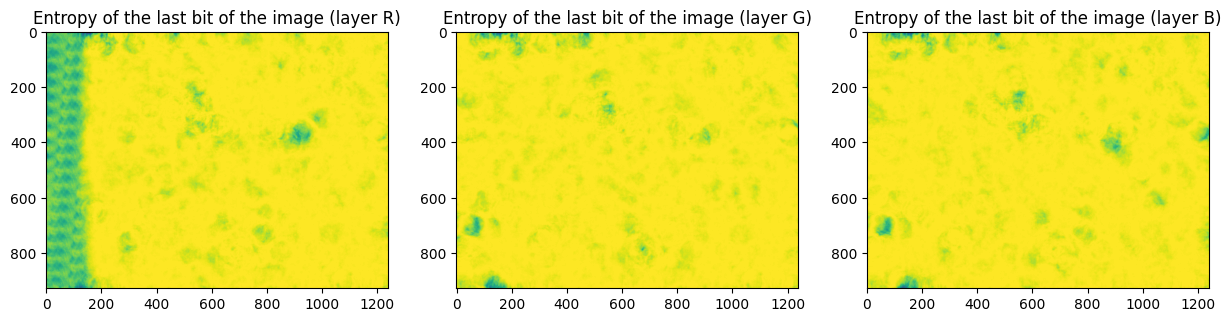

In [159]:
from src.analysis.least_significant_bit import least_significant_bit_image, generate_entropy_image

# Check entropy of the last bit of the image
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, layer_id in zip(axes, range(3)):
    ax.set_title(f'Entropy of the last bit of the image (layer {"RGB"[layer_id]})')
    entropy_image = generate_entropy_image(
        least_significant_bit_image(encoded_image[:,:,layer_id]),
        40
    )
    ax.imshow(entropy_image)
plt.savefig("../docs/entropy_encoded_image.png")
plt.show()